This notebook can be used to plot the distribution of similarity scores on the selected image pairs

In [1]:
from pathlib import Path
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import torch
import collections.abc as collections

sys.path.append("Hierarchical-Localization")

from hloc.utils.parsers import parse_image_lists
from hloc.utils.io import list_h5_names

In [2]:
def parse_names(prefix, names, names_all):
    if prefix is not None:
        if not isinstance(prefix, str):
            prefix = tuple(prefix)
        names = [n for n in names_all if n.startswith(prefix)]
        if len(names) == 0:
            raise ValueError(
                f'Could not find any image with the prefix `{prefix}`.')
    elif names is not None:
        if isinstance(names, (str, Path)):
            names = parse_image_lists(names)
        elif isinstance(names, collections.Iterable):
            names = list(names)
        else:
            raise ValueError(f'Unknown type of image list: {names}.'
                             'Provide either a list or a path to a list file.')
    else:
        names = names_all
    return names


def get_descriptors(names, path, name2idx=None, key='global_descriptor'):
    if name2idx is None:
        with h5py.File(str(path), 'r', libver='latest') as fd:
            desc = [fd[n][key].__array__() for n in names]
    else:
        desc = []
        for n in names:
            with h5py.File(str(path[name2idx[n]]), 'r', libver='latest') as fd:
                desc.append(fd[n][key].__array__())
    return torch.from_numpy(np.stack(desc, 0)).float()

In [5]:
pairs_file = '/outputs/torino/cosplace10_min0.0_skip0+superpoint_aachen+superglue/pairs.txt'

pairs = []
with open(pairs_file, 'r') as f:
    for row in f:
        pairs.append(row)

In [3]:
#Path to global descriptors h5 file
descriptors = '/outputs/netvlad10/global-feats-netvlad.h5'
db_descriptors = descriptors

if isinstance(db_descriptors, (Path, str)):
    db_descriptors = [db_descriptors]
name2db = {n: i for i, p in enumerate(db_descriptors)
            for n in list_h5_names(p)}
db_names_h5 = list(name2db.keys())
query_names_h5 = list_h5_names(descriptors)

db_names = parse_names(None, None, db_names_h5)
if len(db_names) == 0:
    raise ValueError('Could not find any database image.')
query_names = parse_names(None, None, query_names_h5)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
db_desc = get_descriptors(db_names, db_descriptors, name2db)
query_desc = get_descriptors(query_names, descriptors)
sim = torch.einsum('id,jd->ij', query_desc.to(device), db_desc.to(device))

In [6]:
scores = []

for pair in pairs:
    im1 = pair.split(' ')[0]
    im2 = pair.split(' ')[1].replace('\n', '')
    scores.append(float(sim[query_names.index(im1), db_names.index(im2)]))

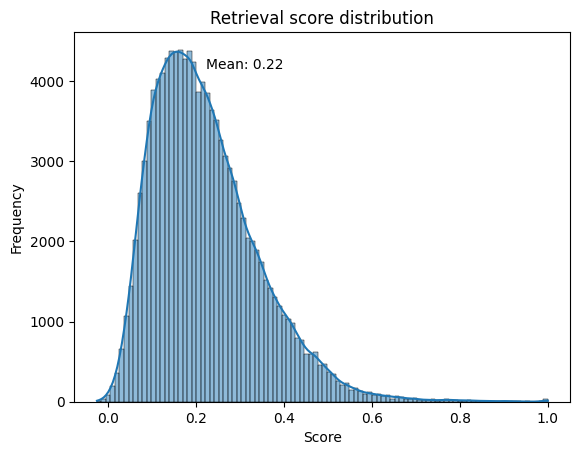

In [7]:
mean_score = np.mean(scores)
sns.histplot(scores, bins=100, kde=True)
plt.title('Retrieval score distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.text(mean_score, plt.gca().get_ylim()[1]*0.9, f'Mean: {mean_score:.2f}', color='black')
plt.show()